In [3]:
%load_ext autoreload
%autoreload 2
import json 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn
import warnings

from functools import reduce
from IPython.display import display, HTML
from musk.core.sql import MySQL

from pandas import DataFrame
from scipy.optimize import curve_fit    



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

FIGURE_QUALITY_MAP = {
    1: dict(figsize=(8, 6), dpi=120),
    2: dict(figsize=(12, 9), dpi=150),
    3: dict(figsize=(16, 9), dpi=250),
}
seaborn.set()
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("xtick", labelsize="x-small")
plt.rc("ytick", labelsize="x-small")


In [3]:
N_BINS = 10000

PROBABILITY_COL = "probability"
SIZE_COL = "size"
CLUSTER_SIZE_HIST_COL = "cluster_size_histogram"

In [4]:
query = "select * from percolation_1d_linear_stats"
mysql = MySQL()
rows = mysql.fetch(query)
df_orig = DataFrame.from_records(rows)


In [5]:


def sum_dict(x,y):
    return {
        index: x.get(str(index), 0) + y.get(str(index), 0) 
        for index in list(x.keys()) + list(y.keys())
    }


def get_average_cluster_size_distribution(df):
    
    n_observations = df.shape[0]
    # Map distributions from STR to JSON
    df = df[CLUSTER_SIZE_HIST_COL].map(
        lambda row: json.loads(row)
    )
    # Sum elements values associated with same keys
    total_dist = reduce(
        lambda x,y: sum_dict(x, y), 
        df.tolist()
    )
    # Convert keys to ints 
    total_dist = {int(key): value for key, value in total_dist.items()}
    
    X = np.array(list(total_dist.keys()))
    Y = np.array(list(total_dist.values()))
    
    # Sort X (and Y in an equivalent fashion) in ascending order
    argsort = np.argsort(X)
    X = X[argsort]
    Y = Y[argsort]    
    
    # Divide by number of observations to get average
    Y = Y / n_observations
    return X, Y 


    


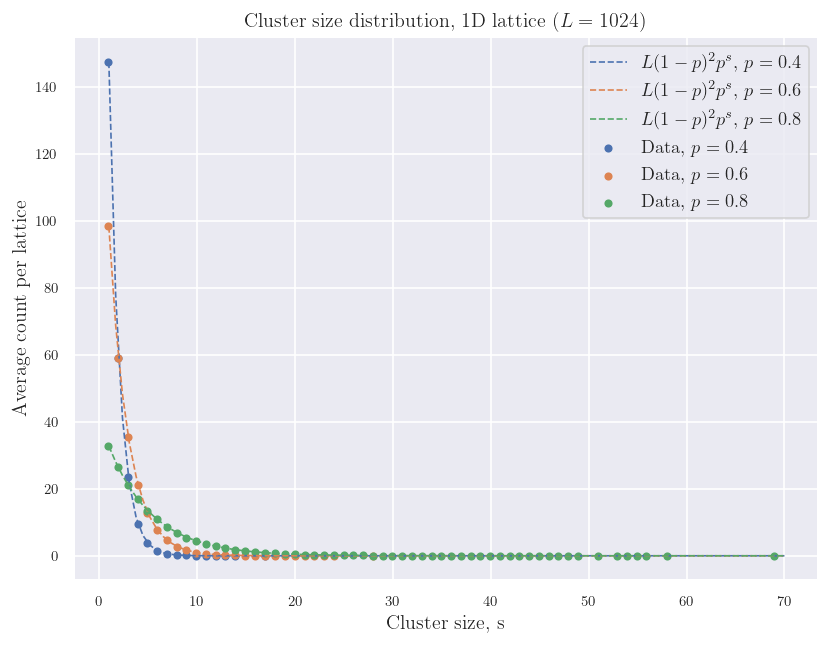

In [65]:
def prob(X, p, size):
    return size * (1-p)**2 * p**X 

size = 1024
df = df_orig.loc[(df_orig["probability"].isin([0.4, 0.6, 0.8])) & (df_orig["size"] == size)]
quality= 1
plt.figure(**FIGURE_QUALITY_MAP[quality])
for group_key, group_df  in df.groupby([PROBABILITY_COL, SIZE_COL]):
    probability, size = group_key 
    X, Y = get_average_cluster_size_distribution(group_df)
    X = size * X / N_BINS

    plt.scatter(X, Y, label="Data, $p=%s$" % (probability), s=15)
    X_fit = np.linspace(1, 70, 100)
    plt.plot(X_fit, prob(X_fit, probability, size), "--", label="$L (1-p)^2 p^s$, $p=%s$" % probability, linewidth=1)
plt.title("Cluster size distribution, 1D lattice ($L=%s$)" % size)
plt.xlabel("Cluster size, s")
plt.ylabel("Average count per lattice")
# plt.yscale('log')
plt.legend()




In [1]:
def normalize_cluster_size_distribution(X, Y, size):
    
    n_observations = len(X)
    
    # Map bin indexes to the (0, 1) range representing cluster_size_ratio 
    X = size * X / N_BINS
    
    # Map counts to probabilitites by first dividing by number of observations
    # ...and then dividing by size of the lattice
    # ...to get average count per lattice cell
    Y = Y  / n_observations 
    return X, Y
    

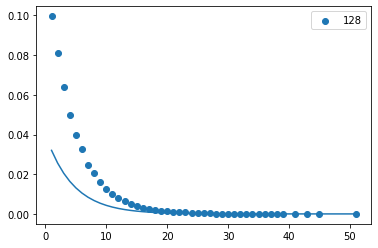

In [21]:
def prob(s):
    return (1-0.8)**2 * 0.8**s


df = df_orig.loc[(df_orig["probability"] == 0.8) & (df_orig["size"] == 128)]
for group_key, group_df  in df.groupby([PROBABILITY_COL, SIZE_COL]):
    probability, size = group_key 
    X, Y = get_average_cluster_size_distribution(group_df)
    X, Y = normalize_cluster_size_distribution(X, Y, size)
    
    plt.scatter(X, Y, label=str(size))
    plt.plot(X, prob(X))
    
    

plt.legend()
    

256
[0.0039 0.0078 0.0117 0.0156 0.0195 0.0234 0.0273 0.0312 0.0351 0.039
 0.0429 0.0507 0.0664 0.0468 0.0625 0.0546 0.0781 0.0742 0.0859 0.082
 0.0703 0.0585 0.0976 0.0898 0.1132 0.1015 0.1093 0.1054 0.0937 0.121
 0.1484 0.1171 0.1328 0.1367 0.125  0.1289 0.1835 0.1445 0.1523 0.1875
 0.1679 0.1562 0.207  0.1406 0.1992 0.164  0.2226]


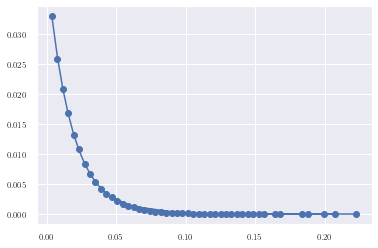

In [155]:

warnings.filterwarnings("ignore")
def prob_dist(X, a, b):
    return (a)*b**(size*X) * (1-b)**2

X = map(int, total_dist.keys())
# map bin_indexes to cluster_size ratios (cluster_size/total_nodes)

# map X to actual cluster sizes 
X = map(lambda ratio: ratio, X)


Y = total_dist.values()
# Normalize Y to get probabilitites
sum_Y = sum(Y)
Y = map(lambda y: y/n_observations/size, Y)
X = np.array(list(X))
Y = np.array(list(Y))

popt, pcov = curve_fit(prob_dist, X, Y, p0=(1, 0.8))
plt.scatter(list(X), list(Y))
plt.plot(X, prob_dist(X, *popt, print_=True))
print(X)
plt.show()
# popt, n_observations

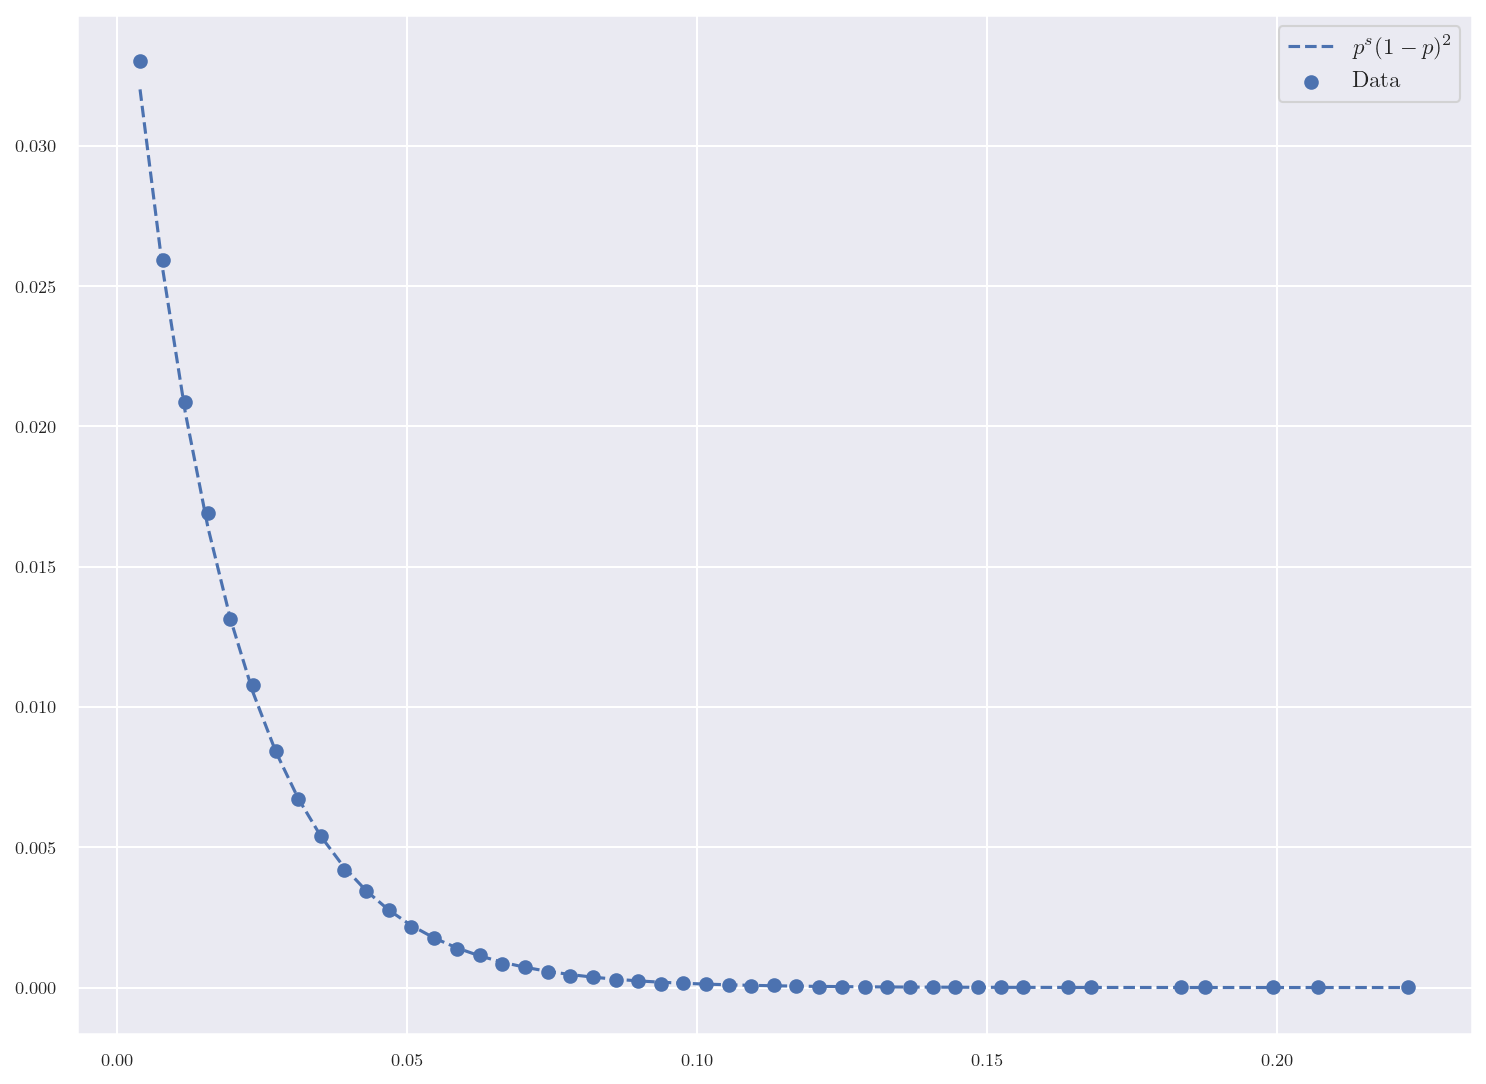

In [185]:
import seaborn
FIGURE_QUALITY_MAP = {
    1: dict(figsize=(6, 4), dpi=120),
    2: dict(figsize=(12, 9), dpi=150),
    3: dict(figsize=(16, 9), dpi=250),
}


seaborn.set()
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("xtick", labelsize="x-small")
plt.rc("ytick", labelsize="x-small")

quality= 2
plt.figure(**FIGURE_QUALITY_MAP[quality])
        
def prob_dist(X):
    return 0.8**(size*X) * (1-0.8)**2


# print(prob_dist(X))
plt.scatter(X, Y, label="Data")
plt.plot(X, prob_dist(X), "--", label=r"$p^s (1-p)^2$")
plt.legend()
plt.show()


# class ClusterSizeDistribution(Plot):

#     title = "Cluster size distribution - 1D"
#     ylabel = "Probability"
#     xlabel = "Cluster size/N"
#     filename = "examples/images/perc_1d_cluster_size.png"
#     figure_quality = 2

In [ ]:
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
# plt.axvline(probability)
import matplotlib.pyplot as plt
plot = PercolationProbabilityPlot()
for size, size_group in df.groupby(["size"]):
    X, Y, Y_errors = [], [], []
    for probability, prob_group in size_group.groupby(["probability"]):
        n_samples = len(prob_group)
        p_estimator = prob_group.mean()['has_percolated']
        
        X.append(probability)
        Y.append(p_estimator)
        z = 2.576
        error = z * (p_estimator * (1 - p_estimator)/n_samples)**0.5
        print(probability, p_estimator, n_samples)
        Y_errors.append(error) 
    
    plot.plot(X, Y, f"N={size}", fit_fn=tanh, err=Y_errors)
        
plot.save()

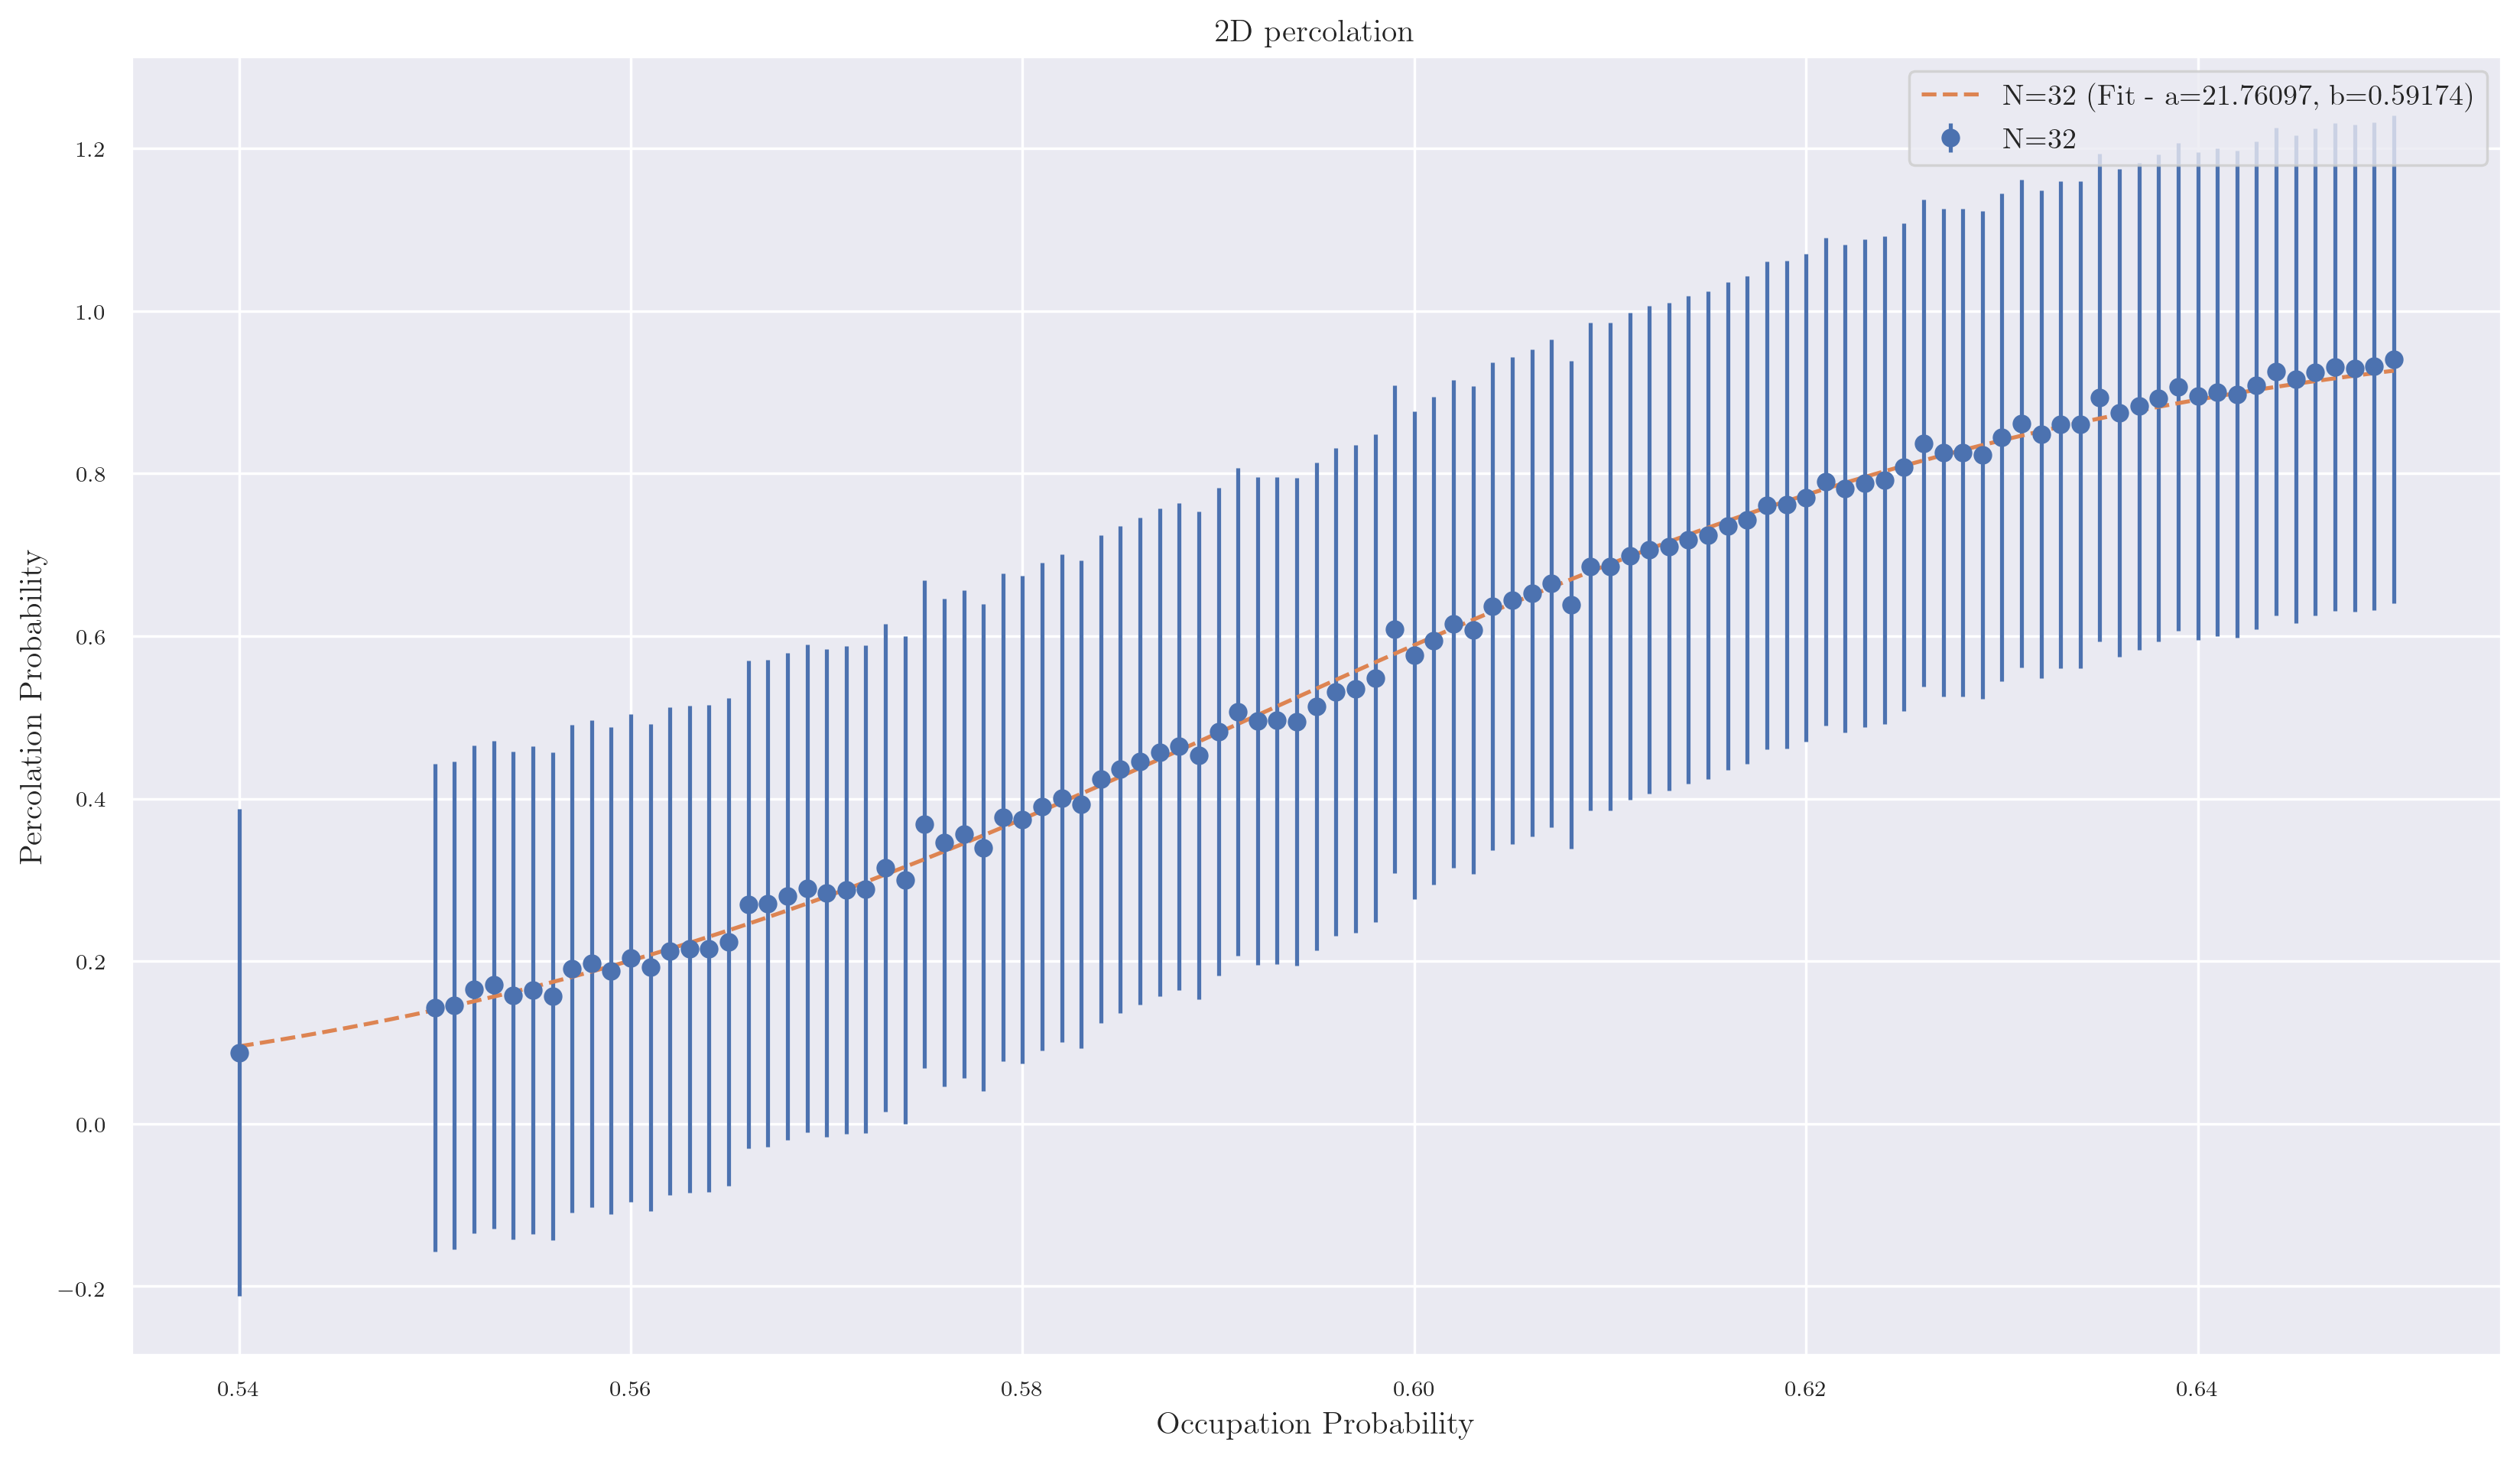

In [19]:
plot = PercolationProbabilityPlot()
for size, size_group in df.groupby(["size"]):
    X, Y = [], []
    for probability, prob_group in size_group.groupby(["probability"]):
        X.append(probability)
        Y.append(prob_group.mean()['has_percolated'])
    plot.plot(X, Y, f"N={size}", fit_fn=tanh)
        
plot.save()

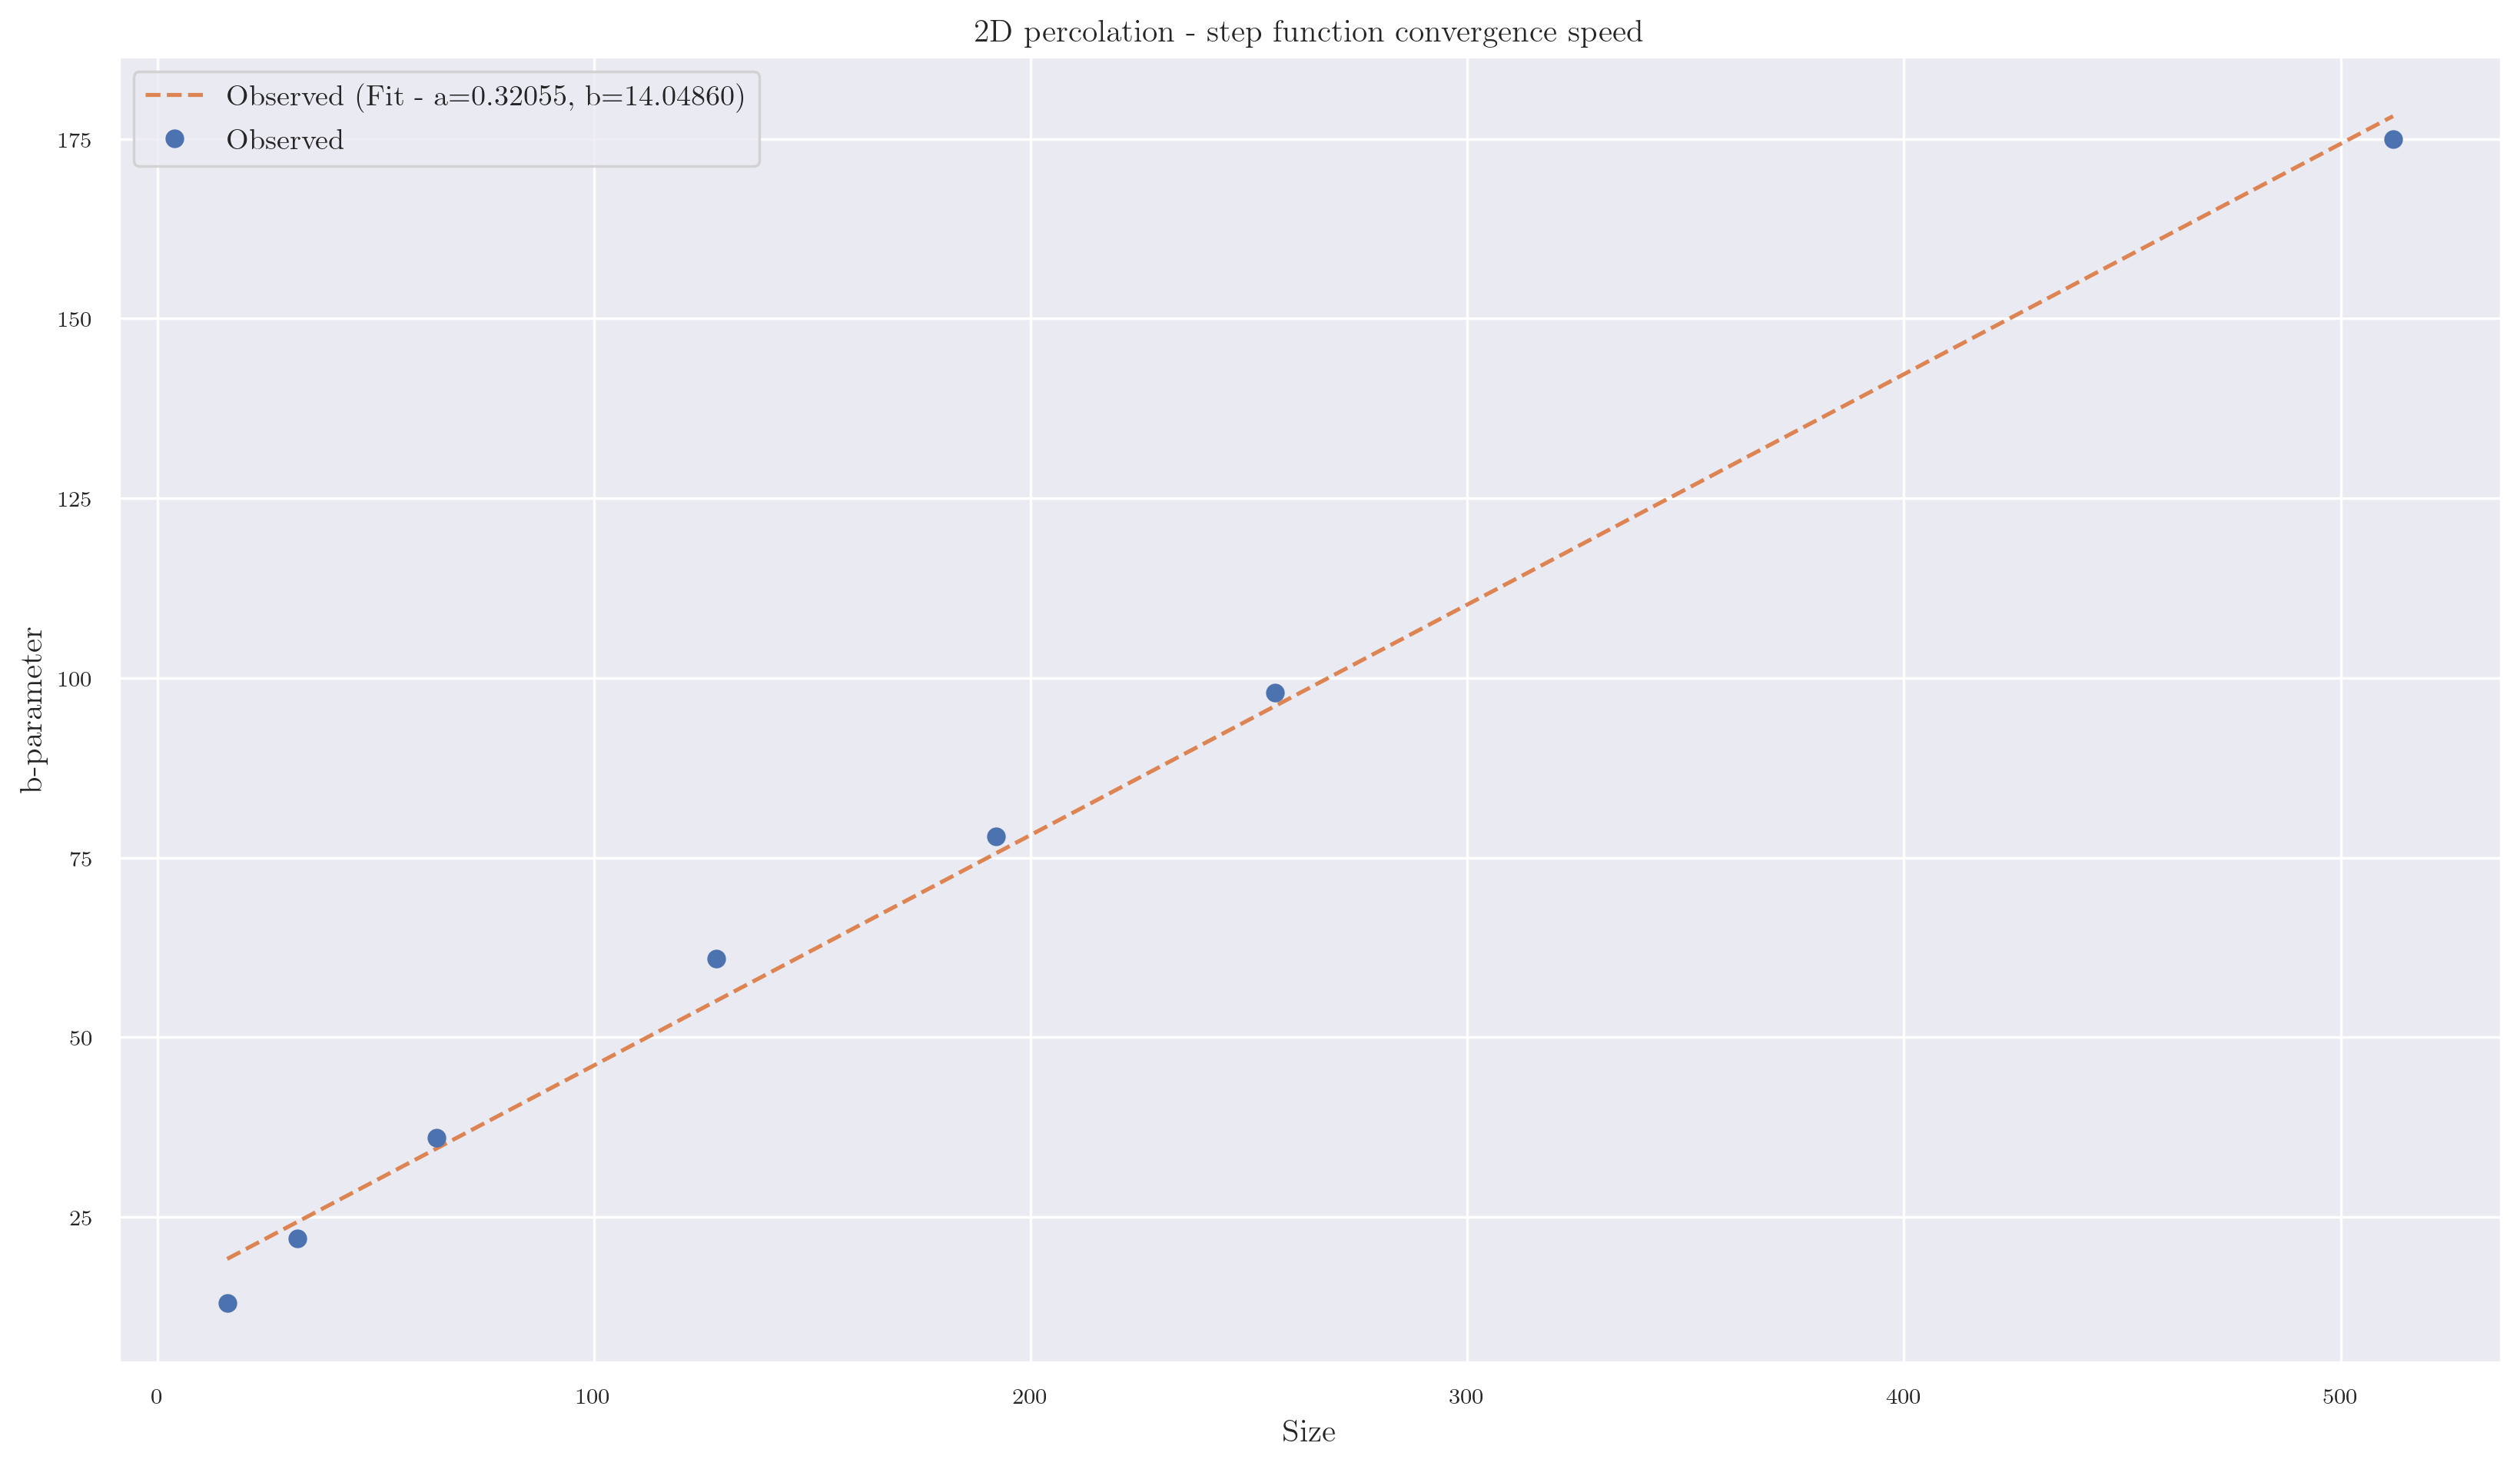

In [17]:
class BParameterPlot(Plot):

    title = "2D percolation - step function convergence speed"
    ylabel = "b-parameter"
    xlabel = "Size"
    filename = "examples/images/perc_2d_b_param.png"
    figure_quality = 3

X = np.array([16, 32, 64, 128, 192, 256, 512])
Y = np.array([13, 22, 36, 61, 78, 98, 175])

plot = BParameterPlot()

plot.plot(X, Y, 'Observed', fit_fn=lambda X, a, b: a*X + b)
plot.save()

